In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from itertools import combinations
from scipy.stats import chi2_contingency
import networkx as nx

pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8-darkgrid")

print(" Libraries imported")

 Libraries imported


In [14]:
BASE_DIR = Path('..')
PROCESSED_DIR = BASE_DIR / "data" / "processed"
KEYWORD_FILE = PROCESSED_DIR / "keyword_features.parquet"
ARTICLES_FILE = PROCESSED_DIR / "articles_with_events.parquet"
OUTPUT_FILE = PROCESSED_DIR / "intersectionality_features.parquet"

In [15]:
print("Loading keyword features...")
df_keywords = pd.read_parquet(KEYWORD_FILE)
print(f" Loaded {len(df_keywords):,} articles")

print("Loading article metadata for case studies...")
try:
    df_articles = pd.read_csv(ARTICLES_FILE)
    print(f" Loaded article metadata: {len(df_articles):,} rows")
except FileNotFoundError:
    df_articles = None
    print("! Article metadata file not found, will skip text-based examples")

Loading keyword features...
 Loaded 49,926 articles
Loading article metadata for case studies...
! Article metadata file not found, will skip text-based examples


 ## 1. Define Intersectional Categories

In [16]:
bias_dimensions = [
    "gender",
    "religion",
    "caste",
    "region",
    "socioeconomic",
    "political",
    "age",
    "disability",
    "urban_rural",
    "language",
]

print("\nIntersectional bias dimensions:")
for dim in bias_dimensions:
    col = f"has_{dim}_bias"
    if col not in df_keywords.columns:
        raise KeyError(f"Expected column '{col}' not found in keyword features")
    biased_articles = df_keywords[col].sum()
    print(f"  - {dim}: {biased_articles:,} articles with bias keywords")

intersection_pairs = list(combinations(bias_dimensions, 2))
print(f"\nTotal intersection pairs: {len(intersection_pairs)}")

# Ensure we have bias_dimension_count (from Notebook 4)
if "bias_dimension_count" not in df_keywords.columns:
    bias_flags = [
        f"has_{dim}_bias"
        for dim in bias_dimensions
        if f"has_{dim}_bias" in df_keywords.columns
    ]
    df_keywords["bias_dimension_count"] = df_keywords[bias_flags].sum(axis=1)


Intersectional bias dimensions:
  - gender: 17,115 articles with bias keywords
  - religion: 6,141 articles with bias keywords
  - caste: 1,194 articles with bias keywords
  - region: 14,133 articles with bias keywords
  - socioeconomic: 5,156 articles with bias keywords
  - political: 18,533 articles with bias keywords
  - age: 16,971 articles with bias keywords
  - disability: 1,336 articles with bias keywords
  - urban_rural: 10,192 articles with bias keywords
  - language: 2,630 articles with bias keywords

Total intersection pairs: 45


 ## 2. Calculate Compound Bias Scores

In [17]:
print("\nCalculating pairwise intersection flags...")

for dim1, dim2 in intersection_pairs:
    col_name = f"{dim1}_{dim2}_intersection"
    df_keywords[col_name] = (
        df_keywords[f"has_{dim1}_bias"] * df_keywords[f"has_{dim2}_bias"]
    ).astype(int)

intersection_cols = [f"{d1}_{d2}_intersection" for d1, d2 in intersection_pairs]

df_keywords["total_intersections"] = (
    df_keywords[intersection_cols].sum(axis=1).astype(int)
)

# Normalize by number of possible intersections given how many bias dimensions are active
max_possible_pairs = (
    df_keywords["bias_dimension_count"] * (df_keywords["bias_dimension_count"] - 1) / 2
)
df_keywords["intersectionality_density"] = np.where(
    max_possible_pairs > 0, df_keywords["total_intersections"] / max_possible_pairs, 0.0
)

# Flag high-intersectionality articles (heuristic threshold)
df_keywords["high_intersectionality"] = (
    df_keywords["intersectionality_density"] >= 0.5
).astype(int)

print(" Compound intersectionality scores calculated")
print(
    f"  Articles with any intersection: {(df_keywords['total_intersections'] > 0).sum():,}"
)
print(
    f"  High-intersectionality articles: {df_keywords['high_intersectionality'].sum():,}"
)

# Per-dimension intersection degree (how many other biases it co-occurs with)
print("\nCalculating per-dimension intersection degrees...")
for dim in bias_dimensions:
    related_cols = []
    for other in bias_dimensions:
        if other == dim:
            continue
        pair = tuple(sorted([dim, other], key=lambda x: bias_dimensions.index(x)))
        col_name = f"{pair[0]}_{pair[1]}_intersection"
        if col_name in df_keywords.columns:
            related_cols.append(col_name)
    df_keywords[f"{dim}_intersection_degree"] = (
        df_keywords[related_cols].sum(axis=1).astype(int)
    )


Calculating pairwise intersection flags...
 Compound intersectionality scores calculated
  Articles with any intersection: 27,361
  High-intersectionality articles: 27,361

Calculating per-dimension intersection degrees...


 ## 3. Heatmaps and Network Graphs


Building intersection statistics for visualization...
 Intersection matrices computed


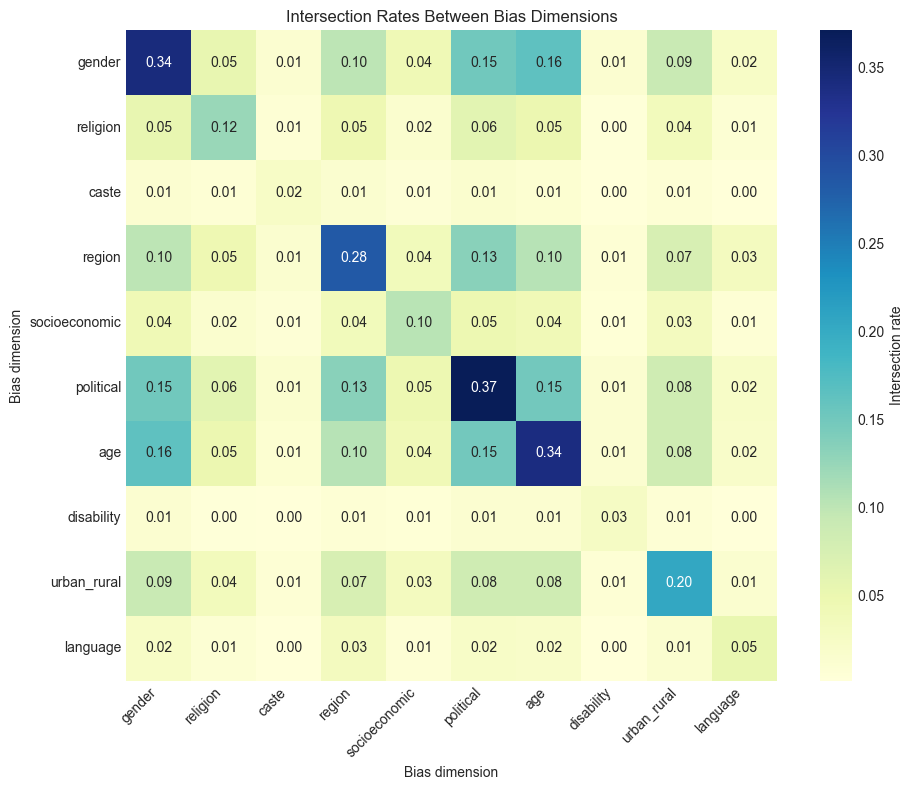

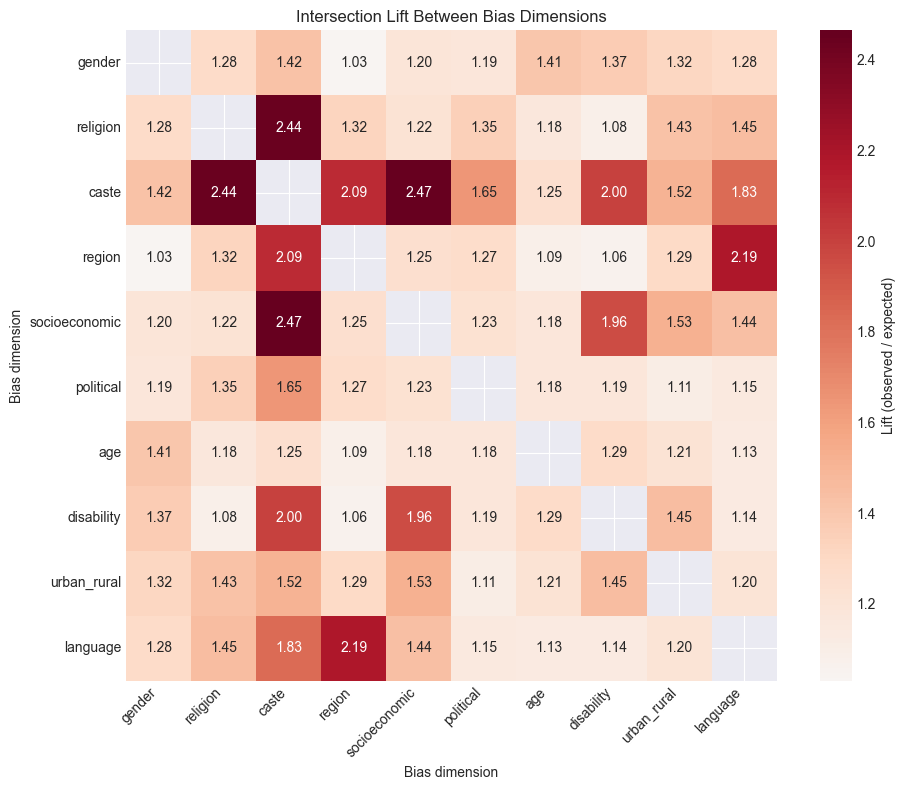


Drawing intersection network graph...


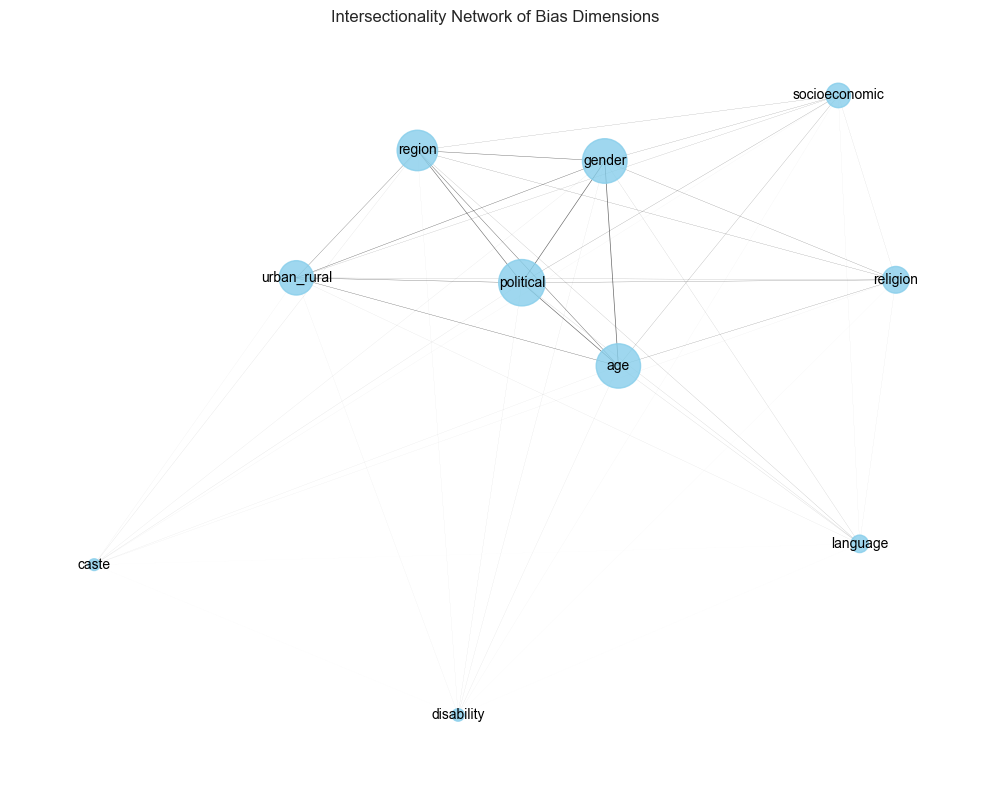

In [18]:
print("\nBuilding intersection statistics for visualization...")

n_articles = len(df_keywords)
dims = bias_dimensions

intersection_counts = pd.DataFrame(0, index=dims, columns=dims, dtype=float)
intersection_rates = pd.DataFrame(0.0, index=dims, columns=dims, dtype=float)
lift_matrix = pd.DataFrame(np.nan, index=dims, columns=dims, dtype=float)

pair_stats_rows = []

for dim1, dim2 in intersection_pairs:
    both_col = f"{dim1}_{dim2}_intersection"
    both = df_keywords[both_col].sum()
    rate_both = both / n_articles

    p1 = df_keywords[f"has_{dim1}_bias"].mean()
    p2 = df_keywords[f"has_{dim2}_bias"].mean()
    expected_rate = p1 * p2 if p1 > 0 and p2 > 0 else np.nan
    lift = rate_both / expected_rate if expected_rate and expected_rate > 0 else np.nan

    intersection_counts.loc[dim1, dim2] = both
    intersection_counts.loc[dim2, dim1] = both
    intersection_rates.loc[dim1, dim2] = rate_both
    intersection_rates.loc[dim2, dim1] = rate_both
    lift_matrix.loc[dim1, dim2] = lift
    lift_matrix.loc[dim2, dim1] = lift

    pair_stats_rows.append(
        {
            "dim1": dim1,
            "dim2": dim2,
            "both_count": int(both),
            "intersection_rate": rate_both,
            "p_dim1": p1,
            "p_dim2": p2,
            "expected_rate": expected_rate,
            "lift": lift,
        }
    )

# Fill diagonal with single-dimension prevalence
for dim in dims:
    count_dim = df_keywords[f"has_{dim}_bias"].sum()
    intersection_counts.loc[dim, dim] = count_dim
    intersection_rates.loc[dim, dim] = count_dim / n_articles
    lift_matrix.loc[dim, dim] = np.nan

pair_stats_df = pd.DataFrame(pair_stats_rows)

print(" Intersection matrices computed")

# Heatmap: intersection rates
plt.figure(figsize=(10, 8))
sns.heatmap(
    intersection_rates,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    square=True,
    cbar_kws={"label": "Intersection rate"},
)
plt.title("Intersection Rates Between Bias Dimensions")
plt.xlabel("Bias dimension")
plt.ylabel("Bias dimension")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Heatmap: lift
plt.figure(figsize=(10, 8))
sns.heatmap(
    lift_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=1.0,
    square=True,
    cbar_kws={"label": "Lift (observed / expected)"},
)
plt.title("Intersection Lift Between Bias Dimensions")
plt.xlabel("Bias dimension")
plt.ylabel("Bias dimension")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Network graph
print("\nDrawing intersection network graph...")

G = nx.Graph()
for dim in dims:
    prevalence = df_keywords[f"has_{dim}_bias"].mean()
    G.add_node(dim, prevalence=prevalence)

for _, row in pair_stats_df.iterrows():
    if row["intersection_rate"] > 0:
        G.add_edge(
            row["dim1"], row["dim2"], weight=row["intersection_rate"], lift=row["lift"]
        )

pos = nx.spring_layout(G, seed=42, k=0.7)

plt.figure(figsize=(10, 8))
node_sizes = [3000 * G.nodes[d]["prevalence"] for d in G.nodes]
edge_widths = [3 * G.edges[e]["weight"] for e in G.edges]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", alpha=0.8)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Intersectionality Network of Bias Dimensions")
plt.axis("off")
plt.tight_layout()
plt.show()

### Key Insights: Intersectionality Across Bias Dimensions

1) Gender, age, political, and region biases form the core intersection cluster – they have the highest intersection rates with each other (first heatmap) and appear as the largest, most connected nodes in the network, indicating that many biased articles combine these dimensions rather than treating them in isolation.

2) Caste, religion, socioeconomic status, and language show disproportionately strong pairings when they do appear – the lift matrix shows very high values for combinations like caste–religion, caste–socioeconomic, socioeconomic–disability, and region–language (lift ≈2–2.5), meaning these intersections occur far more often than would be expected from their individual frequencies.